data is available at https://www.kaggle.com/c/demand-forecasting-kernels-only 



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

In [3]:
data=pd.read_csv('/content/gdrive/MyDrive/demand_data.csv')

In [4]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In the data, we are given sales amount fof 10 unique stores and 50 unique items sales between 2013/01 - 2017/12 in a daily frequency. The task is to forecast sales of all items from all stores for the period of the first 3 months of 2018.

**EDA** and **Cleaning**



In [5]:
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

No missings




In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [8]:
data[data['sales'] == 0]

,date,store,item,sales
64289,2014-01-15,6,4,0


The data is in daily frequency, we should resample it monthly

In [9]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [10]:
data_grouped = data.groupby([pd.Grouper(freq='M'),'store','item'])['sales'].sum().reset_index()

In [11]:
data_grouped

,date,store,item,sales
0,2013-01-31,1,1,328
1,2013-01-31,1,2,911
2,2013-01-31,1,3,547
3,2013-01-31,1,4,346
4,2013-01-31,1,5,276
...,...,...,...,...
29995,2017-12-31,10,46,1723
29996,2017-12-31,10,47,626
29997,2017-12-31,10,48,1537
29998,2017-12-31,10,49,815


It is looking very good so far

In [12]:
monthly_sales = data_grouped.groupby(['date'])[['sales']].sum().reset_index()

In [13]:
monthly_sales.head()

,date,sales
0,2013-01-31,454904
1,2013-02-28,459417
2,2013-03-31,617382
3,2013-04-30,682274
4,2013-05-31,763242


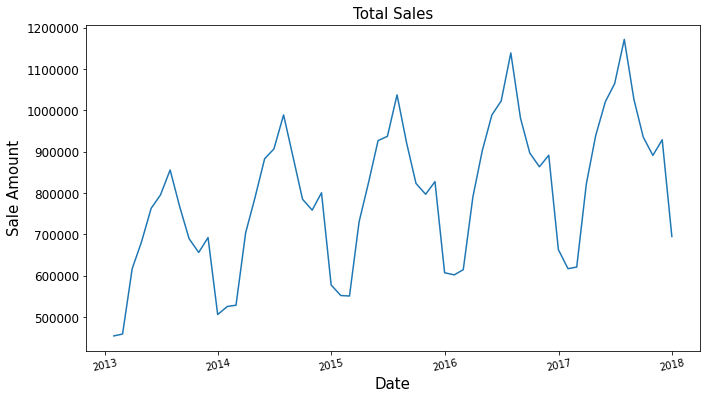

In [14]:
fig = plt.figure(figsize=(11,6)) #figuresize
ax = sns.lineplot(x='date',y='sales', data=monthly_sales)

plt.ticklabel_format(style='plain', axis='y') #converting yticks from scientific to plain

#axis labels and title
plt.title('Total Sales', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sale Amount', fontsize=15)
plt.xticks(rotation=12, fontsize=10)
plt.yticks(fontsize=12)

plt.show()

The good thing about the Facebook's Prophet, we do not need to consider about stationarity of time series. In contrast to ARIMA, Prophet uses trend, seasonality and holiday effects as regressors. 



In [15]:
#Lets firstly make an initial yearly forecast for total sales

#Prophet requires exactly two columns ds and y. where ds is the date (YYYY-MM-DD format) and y is the time series
monthly_sales.columns = ['ds','y']

#let's make 2017 test set
train = monthly_sales[monthly_sales['ds'] < '2017']
test = monthly_sales[monthly_sales['ds'] > '2017']

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


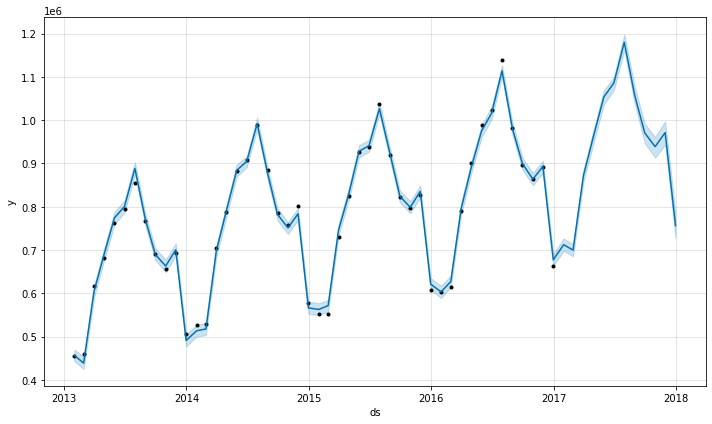

In [16]:
#Baseline model
model=Prophet()
model.fit(train)
future=model.make_future_dataframe(periods=12,freq='M')
forecast=model.predict(future)
model.plot(forecast, uncertainty=True)
plt.show()


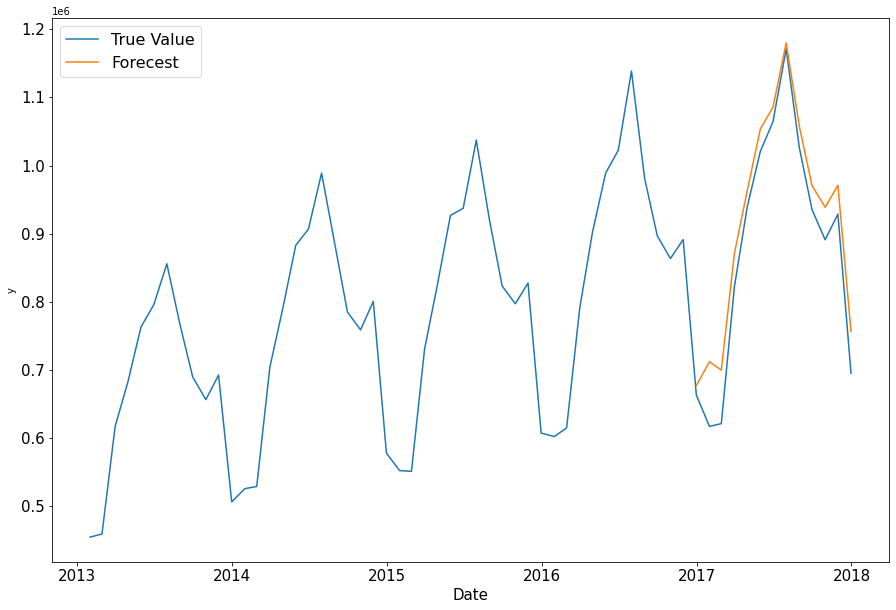

In [17]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1 = sns.lineplot(x='ds', y='y', data=monthly_sales, label='True Value')
ax1 = sns.lineplot(x='ds', y='yhat', data=forecast[forecast['ds']>'2016-12'], label='Forecest')
ax1.set_xlabel("Date", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=16)
plt.show()

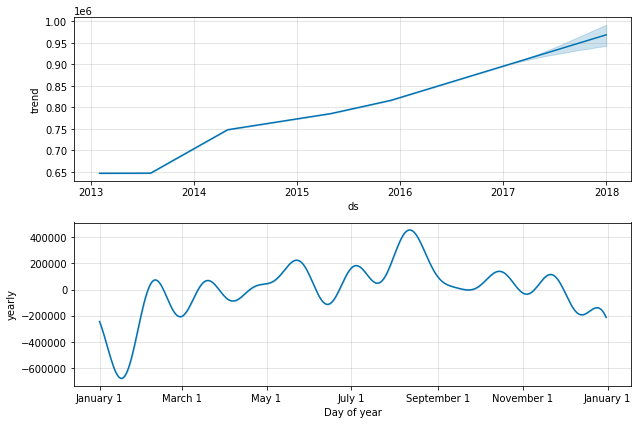

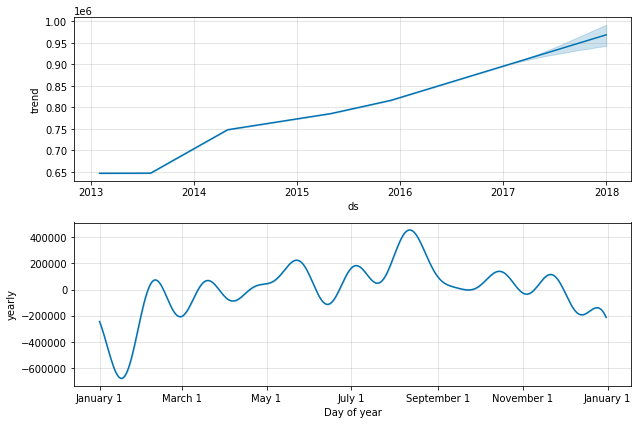

In [18]:
model.plot_components(forecast)


In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
print(mean_absolute_percentage_error(test['y'], forecast[forecast['ds']>'2017-01']['yhat']))

5.663173354637049


The forecast is out with an average of %5.66 from the true value.


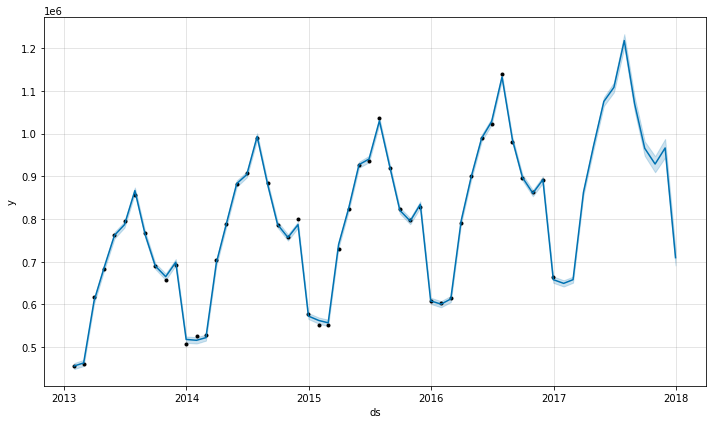

In [21]:
#Let's tune the model 
model=Prophet(growth='linear', seasonality_mode='multiplicative', daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model.fit(train)
future=model.make_future_dataframe(periods=12,freq='M')
forecast=model.predict(future)
model.plot(forecast, uncertainty=True)
plt.show()

In [22]:
list(forecast['yhat'][-12:])

[649419.5752101605,
 658030.9149249187,
 862257.9969341313,
 970636.6120185697,
 1075489.451100471,
 1108534.4264190379,
 1218163.3317334207,
 1069616.2450689422,
 965768.7321369372,
 928953.9599418605,
 966587.8664025982,
 709663.2314232128]

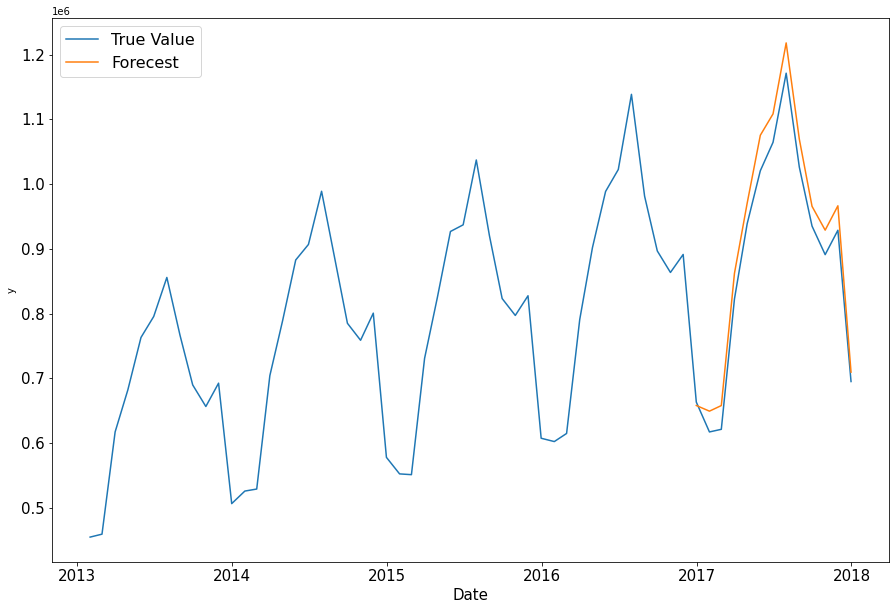

In [23]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1 = sns.lineplot(x='ds', y='y', data=monthly_sales, label='True Value')
ax1 = sns.lineplot(x='ds', y='yhat', data=forecast[forecast['ds']>'2016-12'], label='Forecest')
ax1.set_xlabel("Date", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=16)
plt.show()

In [24]:
print(mean_absolute_percentage_error(test['y'], forecast[forecast['ds']>'2017-01']['yhat']))

4.220651402859232


We managed to drop MAPE to 4.22. Now, Let's continue with individual store-item daily forecasts

In [25]:
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [26]:
print(data['store'].nunique(), data['item'].nunique())

10 50


In [27]:
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


There are 10 distinct stores and 50 distinct items.

In [28]:
store_sales = data.groupby(['date','store'])['sales'].sum().reset_index()

In [29]:
store_sales.head()

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032


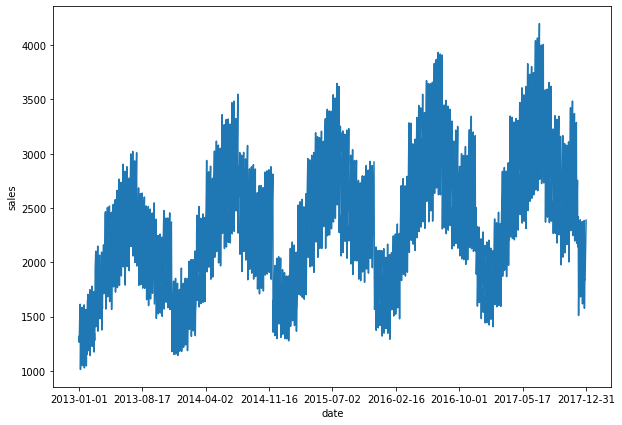

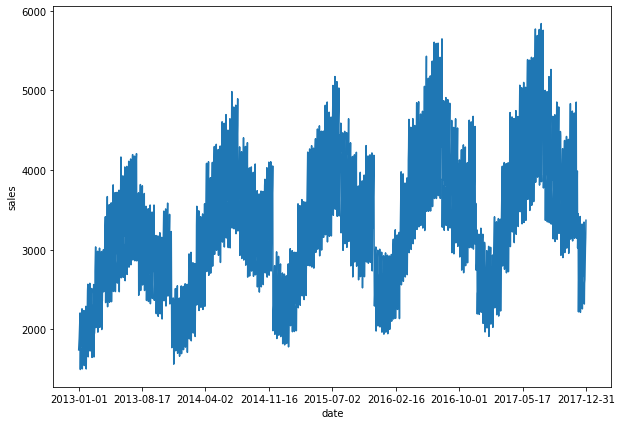

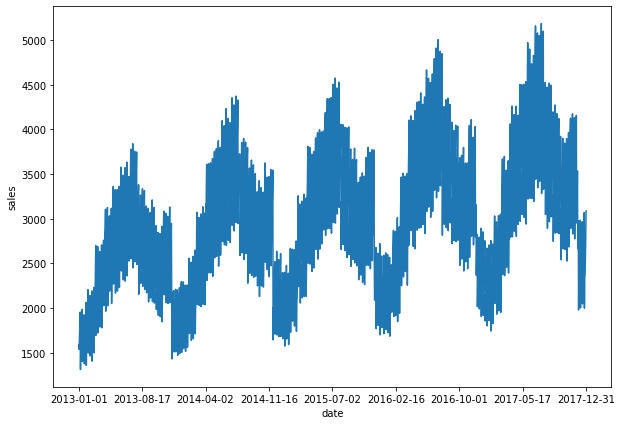

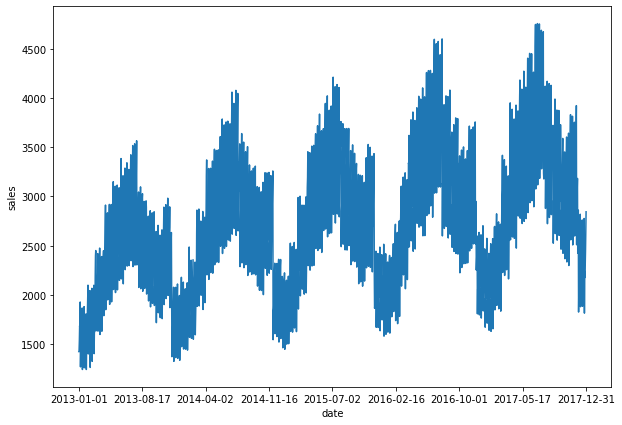

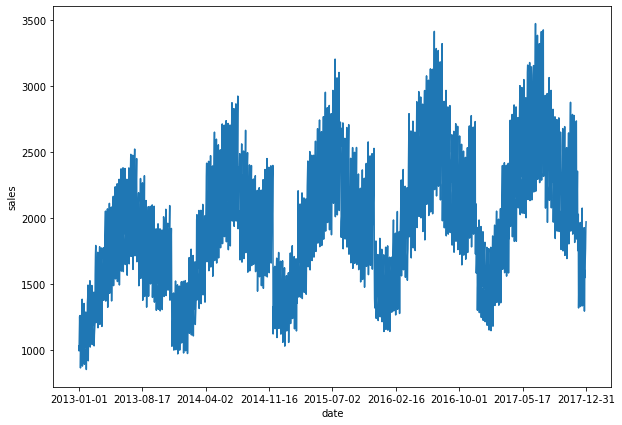

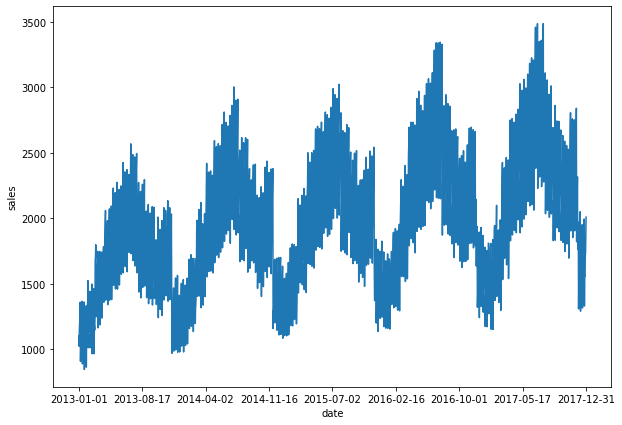

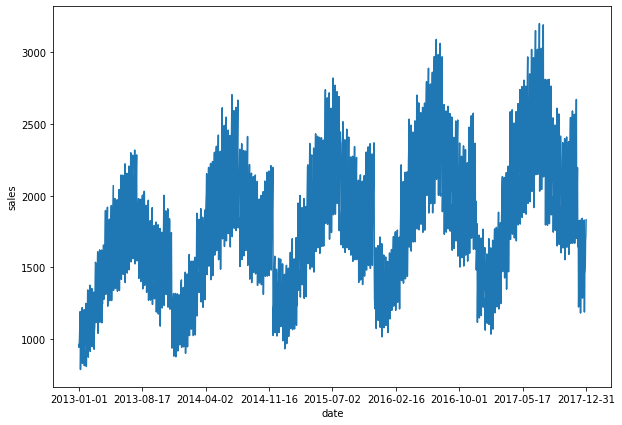

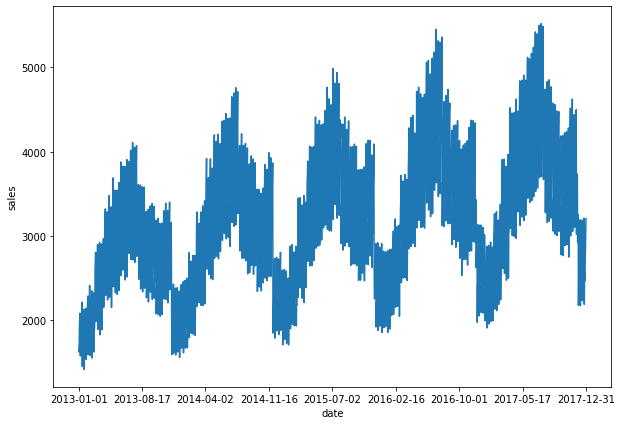

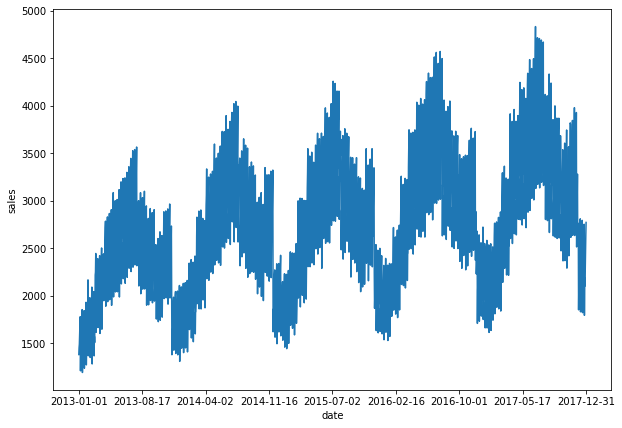

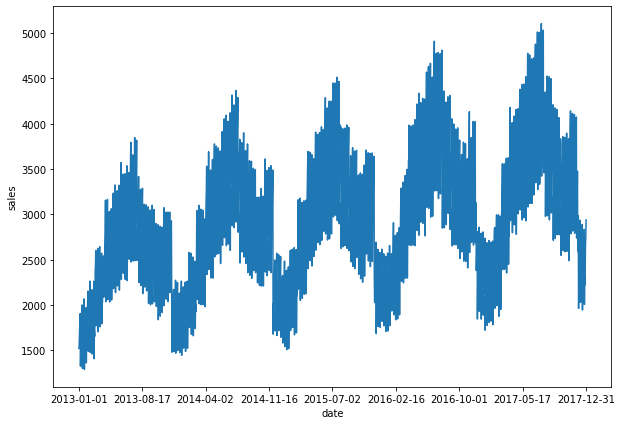

In [30]:
for i in store_sales['store'].unique():
  plt.figure(figsize=(10,7))
  ax1 = sns.lineplot(x='date', y='sales', data=store_sales[store_sales['store']==i])
  ax1.set(xticks=store_sales['date'][0::(len(store_sales) // 8)])
  plt.show()

all stores shows similar pattern. 

In [33]:
data.reset_index(inplace=True)
unique_stores = data['store'].unique()
unique_items = data['item'].unique()

forecast_list = []
for i in unique_stores:
  for j in unique_items:
    data_train = data[(data['store']==i)&(data['item']==j)].drop(['store','item'],axis=1)
    data_train.columns = ['ds','y']
    model=Prophet(growth='linear', seasonality_mode='multiplicative', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    model.fit(data_train)
    future=model.make_future_dataframe(periods=90,freq='D')
    forecast=model.predict(future)
    forecast = list(forecast['yhat'][-90:])
    stores = [i for _ in range(len(forecast))]
    items = [j for _ in range(len(forecast))]
    l = [stores, items, forecast]
    forecast_list.append(l)


In [67]:
l = []
for i in range(len(forecast_list)):
  l.append([list(x) for x in zip(*forecast_list[i])])

In [73]:
l = np.array(l).reshape(45000,3)

In [80]:
columns = ['store','item','sales']

df= pd.DataFrame(l,columns=columns)


In [79]:
#Let's check an example check forecasts for store 7 and item 23
item_23 = df[(df['store']==7) &(df['item']==23)]
item_23['date'] = pd.date_range('2018-01-01','2018-03-31')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



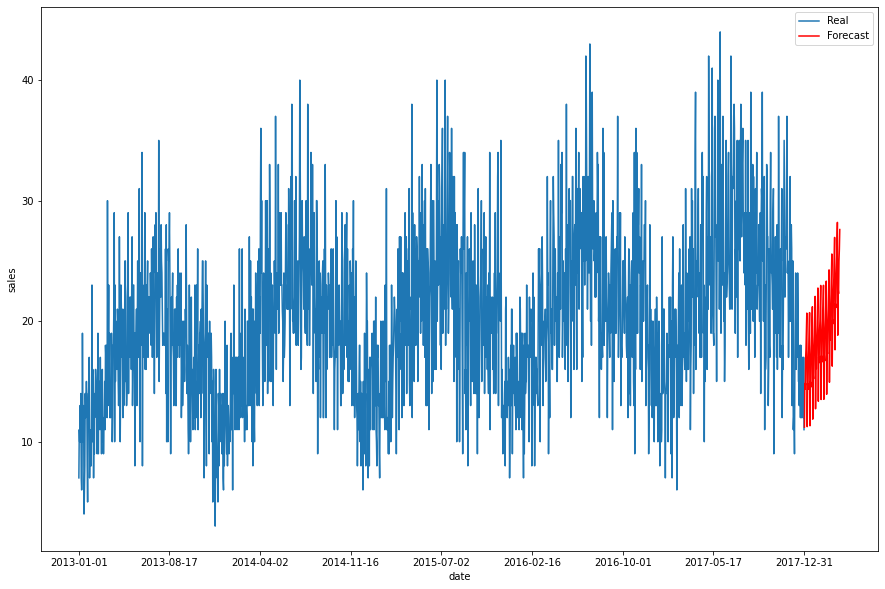

In [86]:
plt.figure(figsize=(15,10))
ax1 = sns.lineplot(x='date', y='sales', data=data[(data['store']==7) &(data['item']==23)], label='Real')
ax1= sns.lineplot(x='date', y='sales', data=item_23, color='red',label='Forecast')
ax1.set(xticks=store_sales['date'][0::(len(store_sales) // 8)])
plt.show()

In [81]:
data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
